In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pickle
from IPython.display import display
import math
import seaborn as sns
from statistics import mean
import pprint

# Reading pymol log files:

This function extracts pymol log files in the directory to extract the RMSD of BCL-XL protein after alignment. The alignment and RMSD calculation are performed in pymol and the output log file for each protein complex contains the corresponding RMSD ($\mathring A$).

In [20]:
def readPymol_log(filename):
    
#     file_name_identifier = (filename.split('/')[-1]).split('.')[0]

    rmsd_dict = {"rmsd": []}
    
    with open (filename) as log_file:
        
        lines = log_file.readlines()
        
        count = 0
        
        for line in lines:
            
            if "Executive: RMSD" in line:
                
                if count == 1:
                
                    rmsd = line.split (" ")[-5]
                
                    rmsd_dict["rmsd"].append(float(rmsd))
                
                    print(rmsd)
                
                count += 1
                
    return rmsd_dict

# Interface Energy Analyzer:

Reading the output file from ROSETTA InterfaceAnalyzer script. According to "In Silico Modeling of PROTAC-Mediated Ternary Complexes: Validation and Application (2019)", the protein-protein complexes with hydrophobic-interface area more than 100 $\mathring A$ can be used to filter docked conformations. In addition to the interface area metrics, interface score, binding free energy and custom ROSETTA packstat scores are also added for reference.

In [3]:
def readSASA(sasaFile):
    
    sasa_dict = {"INTERFACE_SCORE": [], "dG_GROSS": [], "dG_SEPERATED": [], "dSASA_HPHOBIC": [], "dSASA_POLAR": [], "dSASA_INT": [], "PACKSTAT": [], "PER_RESIDUE_ENERGY": []}
    
    with open(sasaFile) as fp:
        
        lineCount = 0
        
        Lines = fp.readlines()
        
        for line in Lines:
        
            if lineCount == 2:
                
                Dsasa=line.split()
            
            lineCount += 1
        
    sasa_dict["INTERFACE_SCORE"].append(float(Dsasa[1]))
    
    sasa_dict["dG_GROSS"].append(float(Dsasa[3]))
    
    sasa_dict["dG_SEPERATED"].append(float(Dsasa[5]))
    
    sasa_dict["dSASA_HPHOBIC"].append(float(Dsasa[7]))
    
    sasa_dict["dSASA_POLAR"].append(float(Dsasa[9]))
    
    sasa_dict["dSASA_INT"].append(float(Dsasa[8]))
    
    sasa_dict["PACKSTAT"].append(float(Dsasa[-12]))
    
    sasa_dict["PER_RESIDUE_ENERGY"].append(float(Dsasa[-11]))
        
    return sasa_dict

In [4]:
def readLigand(ligand_file):
    
    ligand_dict = {"minimized_Affinity": [], "minimized_RMSD": [], "rmsd_Anchor": [], "rmsd_Warhead": []}
    
    with open(ligand_file) as fp:
        
        Lines = fp.readlines()
        
    ligand_dict["minimized_Affinity"].append(float(Lines[200]))
    
    ligand_dict["minimized_RMSD"].append(float(Lines[203]))
    
    ligand_dict["rmsd_Anchor"].append(float(Lines[206]))
    
    ligand_dict["rmsd_Warhead"].append(float(Lines[209]))
        
    return ligand_dict

# Interface Energy Breakdown

The interaction between the proteins are measured through the residue-wise interaction energy. Per-residue-energy may provide more insight into the quality of BCL-XL: VHL docking.

In [5]:
def readEnergyBreakdown(energyFile):    
    
    chain_A = str("VLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQPYPTLPPGTGRRIHSYRGHLWLFRDAGTHDGLLVNQTELFVPSLNVDGQPIFANITLPVYTLKERCLQVVRSLVKPENYRRLDIVRSLYEDLEDHPNVQKDLERLTQER")

    chain_Z = str("SQSNRELVVDFLSYKLSQKGYGMAAVKQALREAGDEFELRYRRAFSDLTSQLHITPGTAYQSFEQVVNELFRDGVNWGRIVAFFSFGGALCVESVDKKMQVLVSRIAAWMATYLNDHLEPWIQENGGWATFVELYG")
        
    len_of_chain_A = len(chain_A)
    
    len_of_chain_Z = len(chain_Z)
      
    with open(energyFile) as fp:
        
        Lines = fp.readlines()
        
        peptideLength = int(Lines[-1].split()[6][:-1])
    
    energy_dict = {"Residue_Pairs": [[[0] * len_of_chain_Z for i in range(len_of_chain_A)]*1], "Energy_of_pairs": [[[0] * len_of_chain_Z for i in range(len_of_chain_A)]*1], "Peptide_Residues": [peptideLength*[0]], "Energy_pepRes": [peptideLength*[0]]}
    
    with open(energyFile) as fp:
        
        Lines = fp.readlines()
        
        for line in Lines:
            
            if line.split()[7] != "onebody" and line.split()[7] != "restype2":
                
                chain1 = line.split()[3]
                
                chain2 = line.split()[6]
                
                energy = line.split()[-2]
                
                if chain1[-1] != chain2[-1]:
                    
                    residue_pair = "{}-{}".format(chain1, chain2)
                    
                    if residue_pair not in energy_dict["Residue_Pairs"]:
                    
                        energy_dict["Energy_of_pairs"][0][int(chain1[:-1])-1][int(chain2[:-1])-len_of_chain_A-1] = (float(energy))
                        
                        energy_dict["Peptide_Residues"][0][int(chain2[:-1])-1] = line.split()[7]
                        
                        energy_dict["Energy_pepRes"][0][int(chain2[:-1])-1] += float(energy)
    
#     energy_dict["Energy_pepRes"][0] = [num/(sum(energy_dict["Energy_pepRes"][0])) for num in energy_dict["Energy_pepRes"][0]]
    
    energy_dict["Energy_pepRes"][0] = [round(num, 3) for num in energy_dict["Energy_pepRes"][0]]
                                             
    return energy_dict    

# Protein Docking Score:

BCL-XL:VHL docked conformation rescoring according to DFIRE2 force field. DFIRE2 scoring function is based on the stochastic information regarding residue-residue interactions from known protein-protein interactions.

In [6]:
def readLDScore(scoreFile):
    
    score_fn = ((scoreFile.split("/")[-1]).split("_")[1]).split(".")[0]
    
    score_key = "score_{}".format(score_fn)
    
    score_dict = {score_key: []}
    
    with open(scoreFile) as fp: 
        
        lineCount = 0
        
        Lines = fp.readlines()
        
        for line in Lines:
            
            score_dict[score_key].append(float(line.rstrip()))
            
            lineCount += 1
            
    score_dict[score_key] = score_dict[score_key][:25]
            
    return score_dict 

In [7]:
def peptideResidueEnergyContribute(dockingScore_list, PLG_dataframe):
    
    avgResidueEnergyDF = {"ID": [], "peptideSequence": [] , "avgResidueEnergy": []}
    
    for peptide in range(len(dockingScore_list)):
        
        avgResidueEnergyDF["peptideSequence"].append(PLG_dataframe["sequence"][peptide])
        
        avgResidueEnergyDF["ID"].append(PLG_dataframe["ID"][peptide])
        
        residueEnergy = dockingScore_list[peptide]["Energy_pepRes"]
        
        avgResidueEnergyDF["avgResidueEnergy"].append([ round((sum(x)/len(residueEnergy)),3) for x in zip(*residueEnergy) ])
        
    return pd.DataFrame.from_dict(avgResidueEnergyDF)

# Correlation Matrix:

The correlation between two separate measures are computed below. This correlation would help us understand how to filter the structures. 

In [8]:
def correlationArrayfromDF(dataFrame, correlation_base):
    
    correlation_array = []
    
    column_index = 0
    
    for column in dataFrame:
        
        data_1 = (dataFrame[column]).tolist()
        
        data_2 = (dataFrame[correlation_base]).tolist()
        
        [float(i) for i in data_1]
        
        [float(i) for i in data_2]
   
        corr, _ = pearsonr(data_1, data_2)
    
        correlation_array.append(corr)
        
    return correlation_array

# Enrichment Factor:

This function computes the enrichment factor based on the RMSD values. Later, applies a custom filter to the dataframe such that the enrichment factor improves for the filtered dataset. 

In [46]:
if __name__ == "__main__":

    path= 'path_to_the_database'

    if path[-1] == "/":
        pass
    
    else:
       
        path = path + "/"

    all_folders = os.listdir(path)

    new_folders = []

    for f in all_folders:
        fold = path + f
        if os.path.isdir(fold) :
            new_folders.append(f)
        
    new_folders.sort()

    list_of_pdbs = []
    
    for folderName in new_folders:
    
        wholePath = path + folderName
    
        outFile = path + "rosetta_relaxed_scoring.csv"
    
        info_dict = {"PDB": [], "INTERFACE_SCORE": [], "dG_GROSS": [], "dG_SEPERATED": [], "dSASA_HPHOBIC": [], "dSASA_POLAR": [], "dSASA_INT": [], "PACKSTAT": [], "PER_RESIDUE_ENERGY": [], "PROTEIN_PEPTIDE_INTER_RESIDUE_PAIRS": [], "TOTAL_INT_ENERGY": []}
    
        scoreFile = wholePath + "/" + "relaxed_per_residue.out"
        
        sasaFile = scoreFile.replace("relaxed_per_residue.out", "pack_score.sc")
        
        pdb_dict = {"PDB": []}
        
        pdb_dict["PDB"] = folderName + "_AZ_relaxed_0001.pdb"
        
        pymol_logfile = wholePath + "/" + folderName + "_rmsd.log"
        
        ligand_file = wholePath + "/" + folderName[:-3] + "ligand.sdf"
        
        RMSD_dict = readPymol_log(pymol_logfile)
        
        ligand_dict = readLigand(ligand_file)
 
        dsasa_dict  = readSASA(sasaFile)

        energy_dict = readEnergyBreakdown(scoreFile)
        
        complex_dict = {**pdb_dict, **RMSD_dict, **ligand_dict, **dsasa_dict, **energy_dict}
        
        complex_Results = pd.DataFrame.from_dict(complex_dict)
        
        list_of_pdbs.append(complex_Results)
        
        allPDBs = pd.concat(list_of_pdbs, ignore_index=True)

    fig, axs = plt.subplots(3, 4, figsize=(30,15))

    axs[0, 0].plot(allPDBs.index, allPDBs["INTERFACE_SCORE"])
    axs[0, 0].set_title("INTERFACE_SCORE")
    axs[0, 1].plot(allPDBs.index, allPDBs["dG_GROSS"], 'tab:orange')
    axs[0, 1].set_title("dG_GROSS")
    axs[0, 2].plot(allPDBs.index, allPDBs["dG_SEPERATED"], 'tab:green')
    axs[0, 2].set_title("dG_SEPERATED")
    axs[0, 3].plot(allPDBs.index, allPDBs["dSASA_HPHOBIC"], 'tab:red')
    axs[0, 3].set_title("dSASA_HPHOBIC")
    axs[1, 0].plot(allPDBs.index, allPDBs["dSASA_POLAR"])
    axs[1, 0].set_title("dSASA_POLAR")
    axs[1, 1].plot(allPDBs.index, allPDBs["dSASA_INT"], 'tab:orange')
    axs[1, 1].set_title("dSASA_INT")
    axs[1, 2].plot(allPDBs.index, allPDBs["PACKSTAT"], 'tab:green')
    axs[1, 2].set_title("PACKSTAT")
    axs[1, 3].plot(allPDBs.index, allPDBs["PER_RESIDUE_ENERGY"], 'tab:red')
    axs[1, 3].set_title("PER_RESIDUE_ENERGY")
    axs[2, 2].plot(allPDBs.index, allPDBs["rmsd"], 'tab:green')
    axs[2, 2].set_title("rmsd")
#         axs[2, 2].plot(completeResults.index, completeResults["score_dfire2"], 'tab:green')
#         axs[2, 2].set_title("score_dfire2")
    
    fig.savefig(path+ "rosetta_relaxed_scoring.png")
    plt.close()
        
    correlationMatrix = []

    for folder in range(len(new_folders)):
    
        dataFrame_corr = allPDBs[["rmsd", "minimized_Affinity", "minimized_RMSD", "rmsd_Anchor", "rmsd_Warhead", "INTERFACE_SCORE", "dG_GROSS", "dG_SEPERATED", "dSASA_HPHOBIC", "dSASA_POLAR", "dSASA_INT", "PER_RESIDUE_ENERGY",]]#, "score_dfire2"]]
    
        correlationArray = correlationArrayfromDF(dataFrame_corr, "rmsd")
    
        correlationMatrix.append(correlationArray)
    
    correlationMatrix = np.array(correlationMatrix)
    
    correlationMatrix_mean = np.zeros(correlationMatrix.shape[1])

    for column in range(correlationMatrix.shape[1]):
    
        correlationMatrix_mean[column] = np.mean(correlationMatrix[:, column])
    
    correlationMatrix_mean
    
#     avgResidueEnergyDF = peptideResidueEnergyContribute(peptideDockingComparison, PLG_dataframe)



17.162
16.919
17.465
17.597
17.571
17.650
11.908
17.722
17.185
17.346
11.491
17.077
11.529
16.998
27.038
11.487
17.505
27.013
17.356
17.207
17.416
16.881
11.786
11.878
17.368
16.807
16.771
16.992
17.061
17.621
27.509
27.027
17.294
17.470
16.952
27.169
17.585
26.704
17.930
26.944
17.107
17.047
26.943
11.990
27.122
27.142
16.896
17.450
17.109
17.541
27.156
26.942
17.591
16.844
17.633
17.537
17.678
17.379
17.375
17.506
17.391
26.662
17.553
17.141
16.791
17.186
26.922
11.696
17.076
17.312
17.257
26.879
17.626
17.228
17.017
11.532
9.602
9.917
10.100
9.740
9.820
9.883
9.783
21.974
10.055
9.749
10.050
9.724
21.944
9.750
9.827
27.244
27.396
27.364
10.594
27.372
27.386
10.803
10.625
27.343
27.304
27.392
10.897
10.850
27.257
10.630
10.748
10.749
10.845
27.152
10.465
10.571
11.021
10.726
27.431
10.695
27.275
27.395
27.389
10.830
10.941
10.792
10.588
10.587
10.854
11.387
11.330
11.872
11.815
12.058
11.854
11.912
12.047
11.968
11.914
24.130
24.124
35.614
16.732
16.076
2.845
3.026
16.219
16.631
16.7

In [47]:
correlationMatrix_mean

array([ 1.        ,  0.19041256,  0.01224258, -0.21900591,  0.10654842,
       -0.21057158, -0.41127819, -0.40916932,  0.35558737,  0.48940431,
        0.44652791, -0.03584946])

In [88]:
def enrichmentFactor (DataFrame, EF_filter="dSASA_HPHOBIC", EF_filter_value=500):
    
    base_EF = (DataFrame[DataFrame["rmsd"] <= 10].shape[0])/DataFrame.shape[0]
    
    print(base_EF)
    
    filtered_DataFrame = DataFrame[DataFrame[EF_filter] >= EF_filter_value]
    
    filtered_DataFrame_RMSD = filtered_DataFrame[filtered_DataFrame["rmsd"] <= 10]
    
    improv_EF = (filtered_DataFrame_RMSD.shape[0])/filtered_DataFrame.shape[0]
    
#     improv_EF = (len(DataFrame[DataFrame[EF_filter] <= EF_filter_value].axes[0]))/len(DataFrame.axes[0])
    
    print(improv_EF)
    
    EF_improv_fraction = improv_EF/base_EF
    
    return improv_EF

In [214]:
# filtered_allPDBs = allPDBs[(allPDBs["dSASA_HPHOBIC"] <=600) | (allPDBs["minimized_Affinity"] <= -20)]

for energy in range(-20, 0, 2):
    
    print(energy)

    filtered_allPDBs = allPDBs[(allPDBs["minimized_Affinity"] <=(energy+2)) & (allPDBs["dSASA_HPHOBIC"] >=energy)]

    print("filtered_allPDBs: {0}".format(filtered_allPDBs.shape[0]))

    filtered_allPDBs_RMSD = filtered_allPDBs[filtered_allPDBs["rmsd"] <= 10]

    print("filtered_allPDBs_RMSD: {0}".format(filtered_allPDBs_RMSD.shape[0]))

    Enrichment_Factor = filtered_allPDBs_RMSD.shape[0]/filtered_allPDBs.shape[0]

    print("Enrichment Factor: {0}".format(Enrichment_Factor))

-20
filtered_allPDBs: 124
filtered_allPDBs_RMSD: 21
Enrichment Factor: 0.1693548387096774
-18
filtered_allPDBs: 164
filtered_allPDBs_RMSD: 27
Enrichment Factor: 0.16463414634146342
-16
filtered_allPDBs: 226
filtered_allPDBs_RMSD: 31
Enrichment Factor: 0.13716814159292035
-14
filtered_allPDBs: 260
filtered_allPDBs_RMSD: 39
Enrichment Factor: 0.15
-12
filtered_allPDBs: 299
filtered_allPDBs_RMSD: 50
Enrichment Factor: 0.16722408026755853
-10
filtered_allPDBs: 325
filtered_allPDBs_RMSD: 54
Enrichment Factor: 0.16615384615384615
-8
filtered_allPDBs: 338
filtered_allPDBs_RMSD: 54
Enrichment Factor: 0.15976331360946747
-6
filtered_allPDBs: 376
filtered_allPDBs_RMSD: 55
Enrichment Factor: 0.14627659574468085
-4
filtered_allPDBs: 408
filtered_allPDBs_RMSD: 64
Enrichment Factor: 0.1568627450980392
-2
filtered_allPDBs: 426
filtered_allPDBs_RMSD: 68
Enrichment Factor: 0.1596244131455399


In [ ]:
improv_fraction = enrichmentFactor (allPDBs, EF_filter="dSASA_POLAR", EF_filter_value=2000)

(array([25.,  6., 13., 10.,  0., 10.,  5.,  8.,  7., 11.]),
 array([-20.09621048, -17.10098839, -14.1057663 , -11.1105442 ,
         -8.11532211,  -5.12010002,  -2.12487793,   0.87034416,
          3.86556625,   6.86078835,   9.85601044]),
 <BarContainer object of 10 artists>)

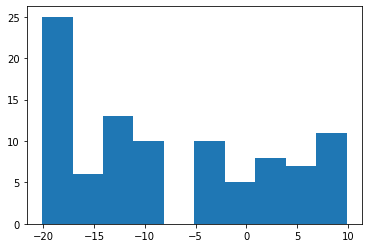

In [213]:
allPDBs_RMSD = allPDBs[allPDBs["rmsd"] <= 10]

allPDBs_RMSD.sort_values(by = "PACKSTAT", ascending = True).reset_index(drop=True)

plt.hist(allPDBs_RMSD["minimized_Affinity"].to_list())


In [190]:
allPDBs = (allPDBs.sort_values(by = "rmsd", ascending = True)).reset_index(drop=True)

allPDBs

,PDB,rmsd,minimized_Affinity,minimized_RMSD,rmsd_Anchor,rmsd_Warhead,INTERFACE_SCORE,dG_GROSS,dG_SEPERATED,dSASA_HPHOBIC,dSASA_POLAR,dSASA_INT,PACKSTAT,PER_RESIDUE_ENERGY,Residue_Pairs,Energy_of_pairs,Peptide_Residues,Energy_pepRes
0,19_183_PPI_AZ_relaxed_0001.pdb,2.794,-19.095329,1.34545,1.191492,0.720996,-859.552,-14.109,-10.956,350.410,307.614,658.025,0.631,-2.271,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,19_125_PPI_AZ_relaxed_0001.pdb,2.845,-18.300680,1.35829,1.128998,1.004177,-857.835,-13.888,-12.812,450.230,263.619,713.849,0.639,-2.306,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,19_286_PPI_AZ_relaxed_0001.pdb,2.903,-18.892799,1.29918,1.086905,0.815252,-852.879,-8.566,-8.086,282.775,410.239,693.013,0.654,-1.552,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,19_167_PPI_AZ_relaxed_0001.pdb,2.977,-18.336229,1.23092,1.218042,0.957737,-843.868,-7.741,-7.625,245.456,151.480,396.935,0.609,-1.213,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,19_127_PPI_AZ_relaxed_0001.pdb,3.026,-18.802540,1.35106,1.130375,0.837535,-850.826,-7.796,-7.575,206.425,237.125,443.551,0.528,-2.420,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,28_249_PPI_AZ_relaxed_0001.pdb,30.254,-16.826031,1.46581,0.271923,0.905120,-866.629,-30.138,-28.049,679.488,444.257,1123.745,0.662,-3.296,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
573,2_298_PPI_AZ_relaxed_0001.pdb,32.306,-19.766911,1.87319,0.624556,0.406506,-847.957,-8.663,-8.166,259.880,307.975,567.855,0.634,-2.318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
574,28_36_PPI_AZ_relaxed_0001.pdb,34.304,-0.395590,3.17183,1.406865,0.770759,-847.637,-19.907,-17.489,586.513,447.777,1034.290,0.574,-2.774,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
575,28_175_PPI_AZ_relaxed_0001.pdb,34.306,-14.895400,2.56315,0.276635,0.517792,-854.305,-19.311,-16.164,573.010,434.786,1007.796,0.670,-2.730,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
len(allPDBs["Peptide_Residues"][0])

In [ ]:
def peptideResidueEnergyContribute(allPDBs, peptide_sequence):
    
    avgResidueEnergyDF = {"ID": [], "peptideSequence": [] , "avgResidueEnergy": []}
    
    for peptide in range(len(dockingScore_list)):
        
        avgResidueEnergyDF["peptideSequence"].append(PLG_dataframe["sequence"][peptide])
        
        avgResidueEnergyDF["ID"].append(PLG_dataframe["ID"][peptide])
        
        residueEnergy = dockingScore_list[peptide]["Energy_pepRes"]
        
        avgResidueEnergyDF["avgResidueEnergy"].append([ round((sum(x)/len(residueEnergy)),3) for x in zip(*residueEnergy) ])
        
    return pd.DataFrame.from_dict(avgResidueEnergyDF)



In [ ]:
vertical_axis = math.ceil(allPDBs.shape[0]/3)

fig, axs = plt.subplots(vertical_axis, 3, figsize=(30,45))

fig.tight_layout()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for seq in range(allPDBs.shape[0]):
    
    row = (seq//3)
    
    column = seq%3
    
    axs[row, column].bar(list(range(1,len(peptide_sequence)+1)), allPDBs["avgResidueEnergy"][seq])
    
    axs[row, column].set_xticks(range(1, len(avgResidueEnergyDF["peptideSequence"][seq])+1), list(avgResidueEnergyDF["peptideSequence"][seq]))
    
    axs[row, column].set_title(avgResidueEnergyDF["ID"][seq])
    
    axs[row, column].set_xlabel("Peptide Residues", fontsize=18)
    
    axs[row, column].set_ylabel("Fractional energy", fontsize=18)
    
fig.savefig(path + '/' + "peptideResidueEnergy.png")

In [175]:

chain_A = str("VLRSVNSREPSQVIFCNRSPRVVLPVWLNFDGEPQPYPTLPPGTGRRIHSYRGHLWLFRDAGTHDGLLVNQTELFVPSLNVDGQPIFANITLPVYTLKERCLQVVRSLVKPENYRRLDIVRSLYEDLEDHPNVQKDLERLTQER")

chain_Z = str("SQSNRELVVDFLSYKLSQKGYGMAAVKQALREAGDEFELRYRRAFSDLTSQLHITPGTAYQSFEQVVNELFRDGVNWGRIVAFFSFGGALCVESVDKKMQVLVSRIAAWMATYLNDHLEPWIQENGGWATFVELYG")

len(chain_Z)

136

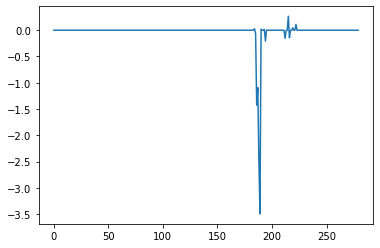

In [181]:
VHL_AA = [x for x in chain_A]
plt.plot(range(0,280), allPDBs["Energy_pepRes"][2])

In [ ]:
plt.scatter(x, y, c=colors, s=sizes, alpha=0.3,cmap='viridis')
plt.colorbar();  # show color scale

(array([ 22.,  63., 157.,  68.,  85.,  42.,  55.,  75.,   7.,   3.]),
 array([ 2.794,  6.076,  9.358, 12.64 , 15.922, 19.204, 22.486, 25.768,
        29.05 , 32.332, 35.614]),
 <BarContainer object of 10 artists>)

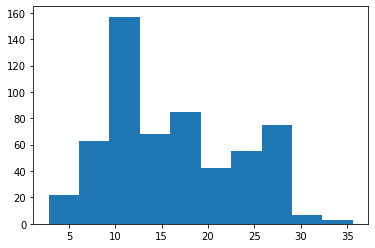

In [165]:
plt.hist(allPDBs['rmsd'].tolist())

(array([ 34.,  83., 111., 112., 122.,  64.,  27.,  11.,   9.,   4.]),
 array([178.648 , 258.9932, 339.3384, 419.6836, 500.0288, 580.374 ,
        660.7192, 741.0644, 821.4096, 901.7548, 982.1   ]),
 <BarContainer object of 10 artists>)

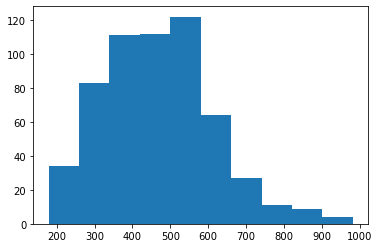

In [166]:
plt.hist(allPDBs['dSASA_HPHOBIC'].tolist())